# Market capitalazination and data discovery
Refer to the [Introduction](/home/gnewy/workspace/starxetp/notebooks/introduction.ipynb) on how to use the notebook.

In this notebook several [Portfolio Analysis](https://tradewithpython.com/portfolio-analysis-using-python) methods are introduced. 
1. Simple plot of the individual asset market capitalization time series

### Execute the cell below once to turn off debugging

In [8]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

### Load data

* The current test dataset is from ___2021-01-01___ to ___01-06-2022___. At this stage the full dataset from the past decade and beyond in unavailable but will be made available in the subsequence phase to support the backtesting. It requires writing a script that will systematically retrieve the data because coindesk, for example, only allows small payloads of data at a time.
* To filter the data set for a shorter time span, change the year (YYYY), month (m), and day (d) of the parameters
   * start_dt ("start date") and _end_date ("end date")
   * Example change the year, month, and day as you desire: 
      * ```start_dt = datetime.date(2022,1,1)``` &nbsp; &nbsp; &nbsp; &nbsp;# implies 2022 January 01; (must be ${\ge}$ 2021 January 01)
      * ```end_dt = datetime.date(2022,3,1)``` &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; # implies 2022 March 01; (must be ${\le}$ 2022 June 01)

In [4]:
import sys
sys.path.insert(1, '../lib')
import clsDataETL as etl
import datetime

'''
    To filter data by a date range change one or both date parameters below
'''
start_dt = datetime.date(2022,1,1)
end_dt = datetime.date(2022,3,1)

if debug:
    import importlib
    etl = importlib.reload(etl)

''' Set the data source and temporal range '''
_path = "../data/market_cap_2021-01-01_2022-06-01/"
''' Initialize the dataETL class '''
print("Loading and filtering data ... this may take a while.")
clsETL = etl.ExtractLoadTransform()
''' Load data into dataframe '''
rec_marketcap_df=clsETL.load_data(dataPath=_path, start_date=start_dt, end_date=end_dt)
rec_marketcap_df.dropna(axis=0,how='any',subset='market_cap',inplace=True)
print("Loaded %d rows %s" % (rec_marketcap_df.shape[0],str(rec_marketcap_df.columns)))
''' Transform data with coin ids in columns '''
piv_marketcap_df = rec_marketcap_df.pivot_table(values='market_cap', index=rec_marketcap_df.Date, columns='ID', aggfunc='first')
piv_marketcap_df.dropna(axis=1,how='all', inplace=True)
piv_marketcap_df.reset_index(inplace=True)
print("Data from %s to %s loaded and transformed into a pivot table with %d rows complete!" % (str(rec_marketcap_df.Date.min()),
                                                                    str(rec_marketcap_df.Date.max()),
                                                                    piv_marketcap_df.shape[0]))

All packages loaded successfully!
All packages loaded successfully!
Loading and filtering data ... this may take a while.
Loaded 419 rows Index(['Date', 'ID', 'Symbol', 'market_cap'], dtype='object')
Data from 2022-01-01 to 2022-03-01 loaded and transformed into a pivot table with 60 rows complete!


## Market capitalization of Assets
A simple ___time series plot___ of the daily market capitalization amounts in USD ($) to evaluate their trends. 
* Refer to these instruction for [interacting with the plotly charts](https://plotly.com/chart-studio-help/zoom-pan-hover-controls/) for zoom, pan, hover over, and reset

In [5]:
import plotly.express as px

market_cap_df = piv_marketcap_df.copy()
_min_date = market_cap_df["Date"].min()
_max_date = market_cap_df["Date"].max()
_title = "Market Capitalization from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(market_cap_df, x="Date", y=market_cap_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Index by Market Caps

Apply the [custom market cap index based method](https://medium.com/python-financial-analysis/python-financial-analysis-4-3-market-cap-based-index-329b908f75dc). <br>
* Let ${X}$ = {${x_i | i \in I}$} the set of crypto currency assets; where $I \subset \mathbb{N}$ is an index set 
* respectively the set of asset market capitalization at time ${t}$: ${R}$(${t,X}$) = {${R}$(${t,x_i}$) | ${i \in I}$}

The general approach for gnerating the _market cap index_ follows the steps below
1. sort the all the market cap values in descending order
1. take the of top ${N}$ market capitalization assets ${Y}$ (i.e. top ${N}$ tieckers or assets with highest market cap) at time ${t}$: ${R}$(${t,{Y}}$) = {${R}$(${t,{x_{k_i}}}$) | ${k_i \in I_N}$}; where ${I_N}$ = {${k_i \in I}$}${_{i=1}^{N<n}}$
1. get tickers ${x_{k_i}}$ that belong to those ${N}$, and transform it to a list of “tickers_topN”
1. iterate over the list of _tickers_topN_ marcket cap values to divide each value by the sum of all market cap values for the particular ticker
   * for a time ${t \in \{ T_{min},T_{max}\}}$ the weigted market cap index value at time ${t}$: ${MCI(t,x_{k_i})}$ = ${R(t,x_{k_i}) / \sum_{t = T_{min}}^{T_{max}} {R(t,x_{k_i})}}$


In [9]:
import plotly.express as px

_weighted_market_df = piv_marketcap_df.copy()
_min_date = _weighted_market_df["Date"].min()
_max_date = _weighted_market_df["Date"].max()
_l_coin_ids = list(_weighted_market_df.columns)
_l_coin_ids.remove('Date')

for coin in _l_coin_ids:
    weighted_col_name = "weighted_"+coin
    _weighted_market_df[weighted_col_name]=_weighted_market_df[coin]/_weighted_market_df[coin].sum()

_l_weighted_cols = [x for x in _weighted_market_df.columns if x not in _l_coin_ids]
plot_weighted_market_df = _weighted_market_df[_l_weighted_cols]

_title = "Weighted Market Capitalization Index from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(plot_weighted_market_df, x="Date", y=plot_weighted_market_df.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

## Simple Returns
1. Compute the [percentage change](https://www.investopedia.com/terms/p/percentage-change.asp) between the current and a prior value, for each ticker's market cap value.
   * For a ticker ${x_i}$ the percentage change for any time ${t}$: ${PCT(t,x_i) = R(t,x_i) / R(t-1,x_i)}$
1. Plot the returns to examine coins with high and low ___volatility___.

In [10]:
''' Daily simple returns '''
import datetime
import plotly.express as px

simple_returns_df = piv_marketcap_df.copy()
_min_date = simple_returns_df["Date"].min()
_max_date = simple_returns_df["Date"].max()

simple_returns_df = piv_marketcap_df[_l_coin_ids].pct_change(periods=1)
simple_returns_df["Date"] = piv_marketcap_df["Date"]   #.astype('datetime[ns]')

_title = "Expected Returns from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(simple_returns_df, x="Date", y=simple_returns_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

## Average Daily Returns
* The average daily returns for a ticker is the mean (or average) over a given period
* Calculate the average daily returns for each ticker ${x_i}$: ${ADR(x_i)}$ = ${1 \over {|T_{max}-{T_{min}}|}}$ ${\sum{_{t=T_{min}}^{T_{max}} {PCT(t,x_i)}}}$

In [12]:
print('Average Daily returns(%) of assets:\n')
Avg_daily = simple_returns_df.mean()
print(Avg_daily*100)
#print(Avg_daily)

Average Daily returns(%) of assets:

ID
bitcoin        -0.049808
bitcoin_cash         NaN
cardano        -0.423308
ethereum       -0.286689
litecoin       -0.323675
ripple          0.037348
solana         -0.678866
dtype: float64


## Risk of Daily Returns
The box plot will reveal the:
1. largest spread in the box plot shows the asset with the highest _average daily returns_
1. coin with the positive outliers (dots) translates into a higher average daily return (e.g. )

In [10]:
import plotly.express as px

_title = "Risk Box Plot from "+str(_min_date)+" to "+str(_max_date)

df = simple_returns_df[_l_coin_ids].melt(var_name="quartilemethod")

fig = px.box(df, facet_col="quartilemethod", color="quartilemethod",
             boxmode="overlay", points='all', title=_title)

for col_idx, col_name in enumerate(_l_coin_ids):
    # use: quartilemethod = {linear, inclusive, exclusive}
    fig.update_traces(quartilemethod="linear", jitter=0, col=col_idx)
fig.show()

## Returns Per Unit Risk
1. Calculate each assets's ___standard deviation___  for all time ${t} \in {T_{min},T_{max}}$:
   * ${\sigma(x_i)}$ = ${\sqrt{|ADR(t,x_i) - {R(t,x_i)}| \over (T_{max}-T_{min})}}$
1. Calculate ___periodic standard deviation___ (e.g., annualized standard deviation) but for a given time period:
   * ${\sigma(x_i) \times (T_{max}-T_{min})}$
1. Asset with the higher ratio is better beacuse it has the best ___Return to Risk ratio___
1. Also known as the ___Sharpe Ratio___
   1. it is a measure of risk-adjusted return
   1. it describes how much excess return is  receive for the volatility of holding a riskier asset

In [11]:
from datetime import datetime
import numpy as np

#max_date = simple_returns_df['Date'].max()
#min_date = simple_returns_df['Date'].min()
Ndays = (_max_date - _min_date).days

print("Annualized Standard Deviation Volatality for %s trading days" % (str(Ndays)))
print("of individual coins on the basis of daily simple returns.")
print(simple_returns_df[_l_coin_ids].std().astype('float64')  * np.sqrt(Ndays).astype('float64') * 100.0)
#print(simple_returns_df.std() * np.sqrt(Ndays) * 100)

Annualized Standard Deviation Volatality for 59 trading days
of individual coins on the basis of daily simple returns.
ID
bitcoin         28.023136
bitcoin_cash          NaN
cardano         37.794261
ethereum        35.250054
litecoin        34.945301
ripple          39.423002
solana          46.062114
dtype: float64


## Cummilative Product

Doesn't apply to ETP because it is meant for products with cummalative returns such as those that offer an interest or dividents.<br>
However, assuming zero interest of dividents, the plot shows the behaviour of each asset, based on the market cap, when USD 1.0 is invested.

In [13]:
import plotly.express as px

_investment = 1.0 # USD

_cum_prod_df = market_df.copy()
_l_coin_ids = [col for col in _cum_prod_df if col != 'Date']
_min_date = _cum_prod_df["Date"].min()
_max_date = _cum_prod_df["Date"].max()
_cum_prod_df = _cum_prod_df[_l_coin_ids].pct_change(periods=1)
daily_cummulative_simple_return = (_cum_prod_df[_l_coin_ids]+_investment).cumprod()
daily_cummulative_simple_return = pd.concat([daily_cummulative_simple_return,market_df['Date']],axis=1)

_title = "Daily Cummulative Simple returns/growth of investment from "\
            +str(_min_date)+" to "+str(_max_date)
fig = px.line(daily_cummulative_simple_return, x="Date", y=daily_cummulative_simple_return.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

## Probability distribution of the data
Evaluating the probability distribution simply a statistics exercise and has no relevance to this work.<br>
As you will observe from the charts each asset has a different probability distribution because of it's market cap behaviour over time. 

bitcoin
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000000] [loc=778418899104.554 scale=58437211508.392]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000000] [loc=666220701468.485 scale=112198197636.069]
[distfit] >[pareto    ] [0.09 sec] [RSS: 0.0000000] [loc=-1481894985.333 scale=667702596427.561]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.0000000] [loc=766565978992.041 scale=58247443081.662]
[distfit] >[t         ] [0.09 sec] [RSS: 0.0000000] [loc=2501440958.431 scale=787375509743.781]
[distfit] >[genextreme] [0.26 sec] [RSS: 0.0000000] [loc=666220701468.617 scale=2.409]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.0000000] [loc=-812940731558.978 scale=2146939942.213]
[distfit] >[lognorm   ] [0.16 sec] [RSS: 0.0000000] [loc=666220701468.484 scale=3.970]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.0000000] [loc=662083273843.240 scale=253539355746.330]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000000] [loc=666220701468.485 scale=238331245448.836]


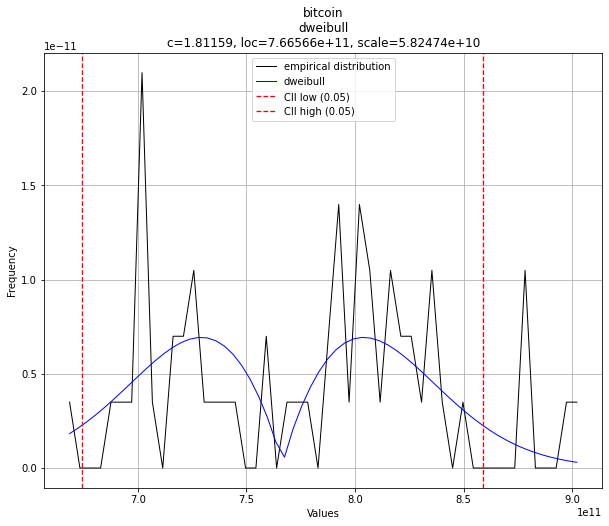

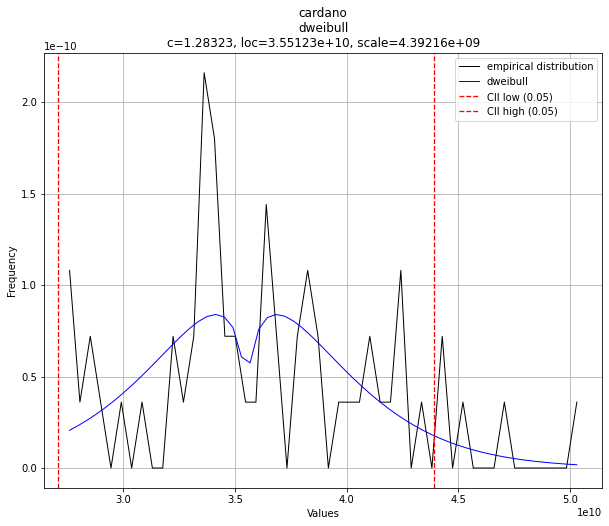

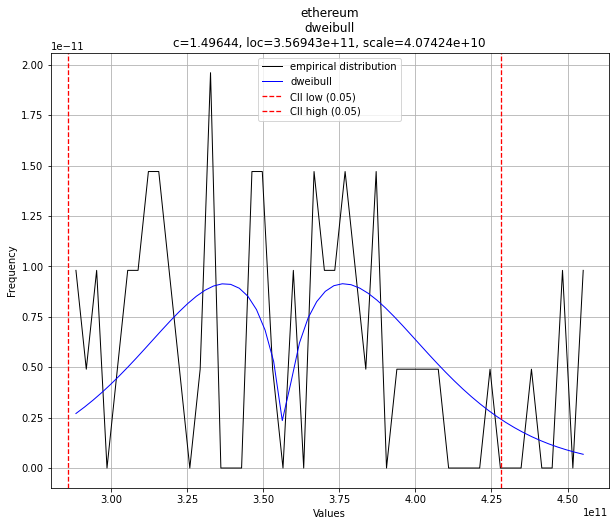

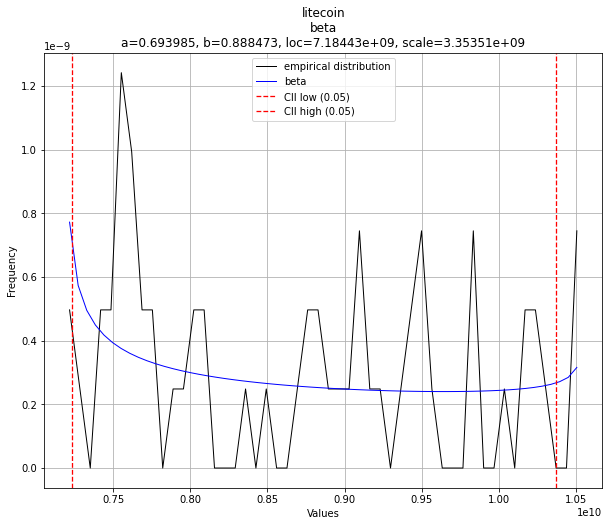

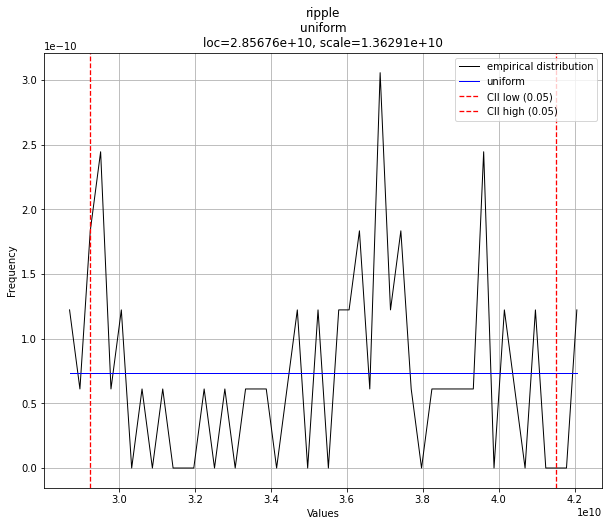

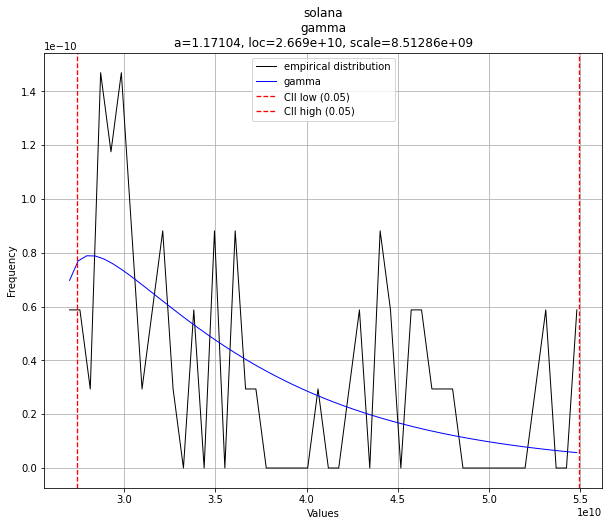

In [ ]:
#%%capture
from distfit import distfit
import numpy as np

_l_dist = []
dist = distfit(distr='popular')
piv_marketcap_df.replace("", np.nan, inplace=True)
piv_marketcap_df.dropna(how='all', axis=1, inplace=True)

''' list of all the numerical data columns '''
_l_num_cols=piv_marketcap_df.select_dtypes(include=np.number).columns.tolist()
_l_num_cols = [col for col in _l_num_cols if col !='bitcoin_cash']
for col in _l_num_cols:
    print(col)
    _col_vals = piv_marketcap_df[col].values
    ''' initialize distfit'''
    dist.fit_transform(_col_vals)
    ''' print the summary results '''
    dist.plot(title=col)


## DEPRECATED
__The sections below are either redundant code or have no relevance to this work but are retain if there is any resuable for offering any future value__ 

In [ ]:
''' DEPRECATED '''
import sys
sys.path.insert(1, '../lib')
import clsDataETL as etl
import pandas as pd

if debug:
    import importlib
    etl = importlib.reload(etl)

''' Initialize the dataETL class '''
path = "../data/market_cap_2021-01-01_2022-06-01/"
clsETL = etl.ExtractLoadTransform(dataPath=path)
''' Get list of data file names '''
_l_fnames = clsETL.get_file_list()
print("Retrieved %d files in dir: %s " % (len(_l_fnames),path))
''' Load data into dataframe '''
data_df = clsETL.load_data(_l_fnmes)
print("Loaded %d rows %s" % (data_df.shape[0],str(data_df.columns)))
''' Transform data with coin ids in columns '''
market_df = clsETL.transfrom_data(data_df, value_col_name='market_cap')
print(market_df.info())
print("Market cap data load & transform complete! ")

All packages loaded successfully!
All packages loaded successfully!


TypeError: get_file_list() missing 1 required positional argument: 'path'

## Filter by date range

In [ ]:
import datetime

start_dt = datetime.datetime(2022,1,1)
end_dt = datetime.datetime(2022,3,1)
market_df=clsETL.fillter_by_date(market_df,start_dt,end_dt)
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 365 to 424
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          60 non-null     datetime64[ns]
 1   bitcoin       60 non-null     float64       
 2   bitcoin_cash  59 non-null     float64       
 3   cardano       60 non-null     float64       
 4   ethereum      60 non-null     float64       
 5   litecoin      60 non-null     float64       
 6   ripple        60 non-null     float64       
 7   solana        60 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 4.2 KB
